# 프로젝트 : 다양한 OCR모델 비교하기 

---------------------------------------------

목표 : Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능 기술 검증 해보기 

`프로젝트 설명 : 우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.`

`지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?`

`OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.`

---------------------------------------------------------------

**루브릭**

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항과 상세기준
1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?  
목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.

2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?  
평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.

3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?  
최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

-----------------------------------------------------------

## Step1. 검증용 데이터셋 준비
`Step설명 : OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.`

`가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.`



In [77]:
import os
import cv2

In [159]:
# 테스트 이미지 경로 
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/input_images_en/func_test'

In [82]:
file_list = os.listdir(work_dir)

### OCR 기능 테스트 이전에 생각하기

정성적 평가를 하려한다. 아래의 평가에 부합하는지 확인할 것이다. 
 
- 광고이미지에서 말하고자하는 주요 정보를 읽어 냈는가?  
- 기울어진 안내판의 정보를 읽어 냈는가?  
- 작고 다양한 글씨체를 읽어 냈는가?  
- 코로나 관련 상황에서 주요 정보를 읽어 냈는가? 

그래서 해당이미지들은 광고, COVID-19포스트, 표지판사진, 작고 다양한 글씨들의 사진들이다. 

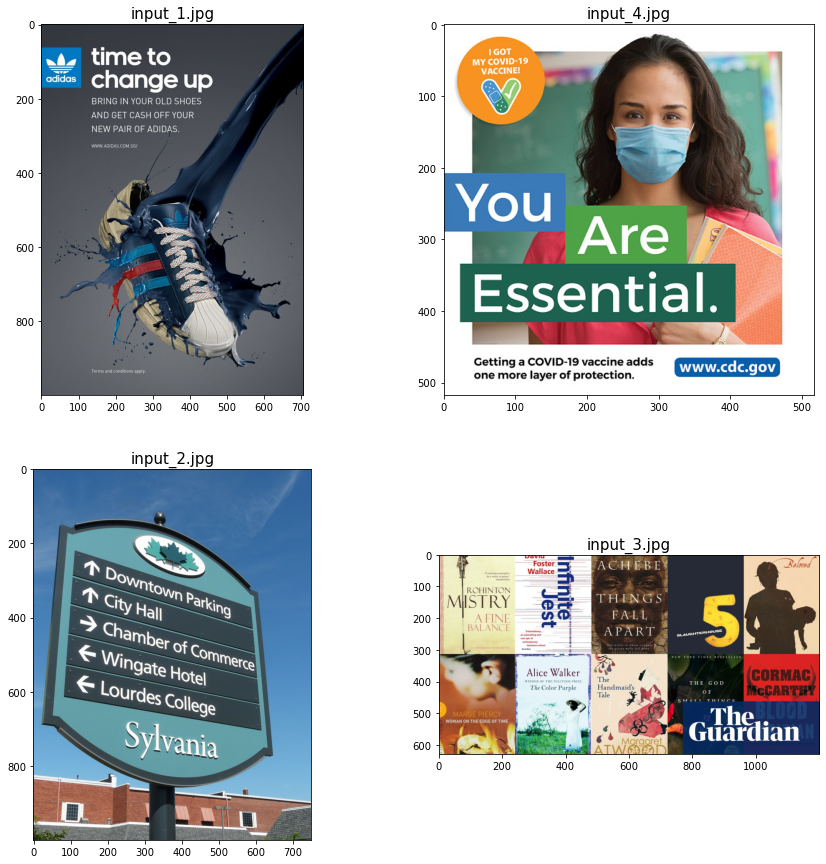

In [121]:
plt.figure(figsize=(15,15))
i=0
for file in file_list:
    plt.subplot(2,2,i+1)
    image_files = os.path.join(work_dir, file)
    image = cv2.imread(image_files)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    i += 1
    plt.title(file, fontsize=15)
    plt.imshow(image)

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
`Step설명 : 위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.`



### 2-1. Google OCR API

In [114]:
# 결과값을 dictionary에 담는다. 
google_ocr_dict = {}

# Text를 인식해서 출력하는 함수 
def detect_text(path, g_key):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print(type(texts))
    #print('Texts:')

    text_list = []
    for text in texts:
        text_list.append(text.description) # 출력된 text description을 리스트에 담기
        #print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))
    
    google_ocr_dict[g_key] = text_list # text list 결과물을 dictionary에 담기 
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

출력물이 길어서 print는 bounds만 하도록 한다. 

In [115]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/JooPJ-ef91ddcc6e4d.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    image_files = os.path.join(work_dir, file)
    detect_text(image_files, file)

-rw-rw-r-- 1 ssac6 ssac6 2346  3월 11 10:27 /home/ssac6/aiffel/ocr_python/JooPJ-ef91ddcc6e4d.json
<class 'proto.marshal.collections.repeated.RepeatedComposite'>
bounds: (251,930),(280,930),(280,941),(251,941)
<class 'proto.marshal.collections.repeated.RepeatedComposite'>
bounds: (322,467),(467,470),(467,494),(322,491)
<class 'proto.marshal.collections.repeated.RepeatedComposite'>
bounds: (253,671),(509,713),(492,813),(237,771)
<class 'proto.marshal.collections.repeated.RepeatedComposite'>
bounds: (377,100),(376,231),(322,231),(323,100)


ditionary에 담아서 확인함. 

In [119]:
for key in google_ocr_dict.keys():        
    print(f"[ {key} ]")
    str_value = ''
    for v in google_ocr_dict[key]:
        str_value += v
        str_value += ' '
    print(str_value)       
    print("------------------------")

[ input_1.jpg ]
time to
change up
adidas
BRING IN YOUR OLD SHOES
AND GET CASH OFF YOUR
NEW PAIR OF ADIDAS.
wwW.ADIDAS.COM.SG/
Terms and conditions apply.
 time to change up adidas BRING IN YOUR OLD SHOES AND GET CASH OFF YOUR NEW PAIR OF ADIDAS. wwW.ADIDAS.COM.SG/ Terms and conditions apply. 
------------------------
[ input_4.jpg ]
I GOT
MY COVID-19
VACCINE!
You
Are
Essential.
Getting a COVID-19 vaccine adds
one more layer of protection.
www.cdc.gov
 I GOT MY COVID-19 VACCINE! You Are Essential. Getting a COVID-19 vaccine adds one more layer of protection. www.cdc.gov 
------------------------
[ input_2.jpg ]
1 DowntowNn Parking
1 City Hall
> Chamber of Commerce
E Wingate Hotel
E Lourdes College
Sylvania
 1 DowntowNn Parking 1 City Hall > Chamber of Commerce E Wingate Hotel E Lourdes College Sylvania 
------------------------
[ input_3.jpg ]
David
Foster
Wallace
Belored
ACHEBE
A towering masterpiece
by a writer of grnius."
INDEPENDENT
ROHINTON
MISTRY
THINGS
FALL
A FINE
BALANCE
APART
E

### 2-2 Keras-ocr

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/ssac6/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/ssac6/.keras-ocr/crnn_kurapan.h5


In [139]:
# 파일리스트의 이미지 url을 가져와 text detect를 함. 평가를 위해 dictionary에 담음 
images = []
prediction_groups = []
keras_ocr_dict = {}
for i, file in enumerate(file_list):    
    image_files = os.path.join(work_dir, file)
    images.append(keras_ocr.tools.read(image_files)) 
    prediction_groups.append(pipeline.recognize([image_files]))
    
    text_list = []
    for j in range(len(prediction_groups[i][0])):
        text_list.append(prediction_groups[i][0][j][0])
        
    keras_ocr_dict[file] = text_list

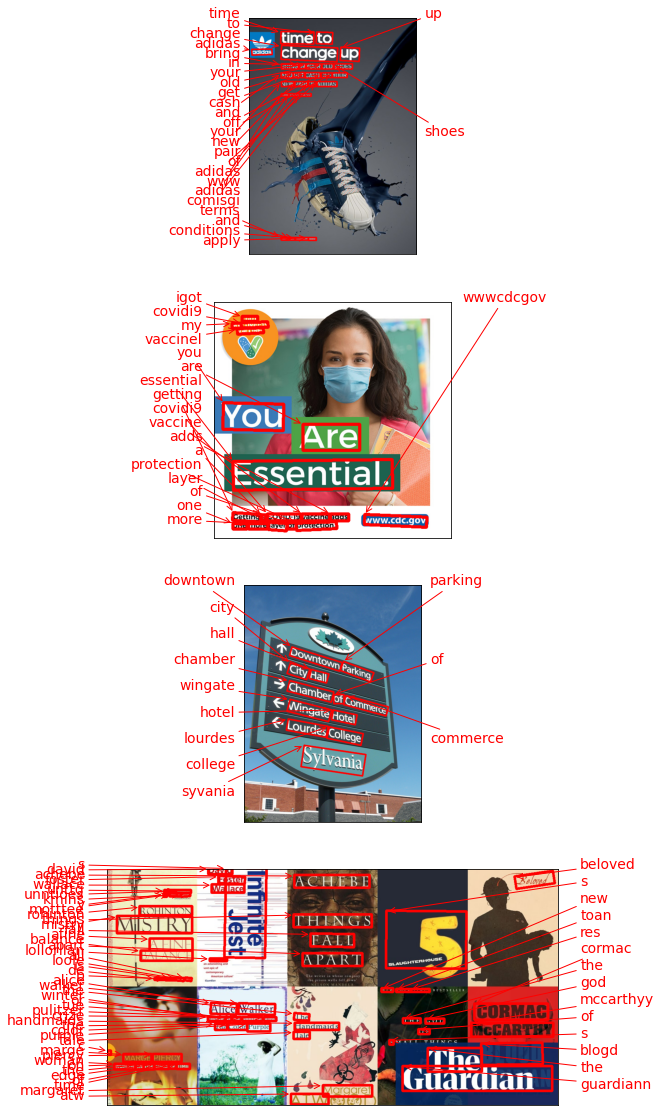

In [141]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 2-3 Tesseract  

`Step설명 : 언어팩 설치 관련해서는 이 페이지를 참고해 주세요. https://blog.daum.net/rayolla/1141`


In [220]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            #print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [226]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
def recognize_images(cropped_image_path_list, file):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    text_list = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng', # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        text_list.append(recognized_data['text'].replace('\n\x0c',''))
        #print(recognized_data['text'])
    print(f"{file} -  Done")
    
    return text_list


In [227]:
tesseract_dict = {}
for i, file in enumerate(file_list):
    image_files = os.path.join(work_dir, file)
    output_dir = work_dir + '/output_' + str(i)
    cropped_image_path_list = crop_word_regions(image_files, output_dir)   
    tesseract_dict[file] = recognize_images(cropped_image_path_list, file)

input_1.jpg -  Done
input_4.jpg -  Done
input_2.jpg -  Done
input_3.jpg -  Done


## Step3. 테스트 결과 정리
`Step설명 : 모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.`



In [212]:
def image_show(idx):
    plt.figure(figsize=(8, 10))
    image_files = os.path.join(work_dir, file_list[idx])
    image = cv2.imread(image_files)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image)

- 광고 이미지

Google OCR API : 
 ['time', 'to', 'change', 'up', 'adidas', 'BRING', 'IN', 'YOUR', 'OLD', 'SHOES', 'AND', 'GET', 'CASH', 'OFF', 'YOUR', 'NEW', 'PAIR', 'OF', 'ADIDAS.', 'wwW.ADIDAS.COM.SG/', 'Terms', 'and', 'conditions', 'apply.']
------------------
Keras-ocr : 
 ['time', 'to', 'change', 'up', 'adidas', 'bring', 'in', 'your', 'old', 'shoes', 'get', 'cash', 'and', 'off', 'your', 'new', 'pair', 'of', 'adidas', 'www', 'adidas', 'comisgi', 'terms', 'and', 'conditions', 'apply']
------------------
Tesseract : 
 ['rg', 'gale', 'ie', '@)', 'cn', 'Qng', '‘ .', 'ae', '‘ .', '@', 'Pint', '|', 'nie', 'iN', 'YOUR', 'Glad', '=', 'HOES', 'AYE', 'ami', 'Or.', '.', 'is', '5', '4Gl Git', 'Wieaal', 'ery', 'a', 'Or', '‘ .', 'AyD)', '\x0c', 'byte', '-', 'FAT TATE erat', 'By.', 'ae', 'S', 'Mi', '“s{5', 'f', 'lermsa', 'nd', '=eia', 'othe', 'ole', 'ees 818', '\x0c', 'Yj']
------------------


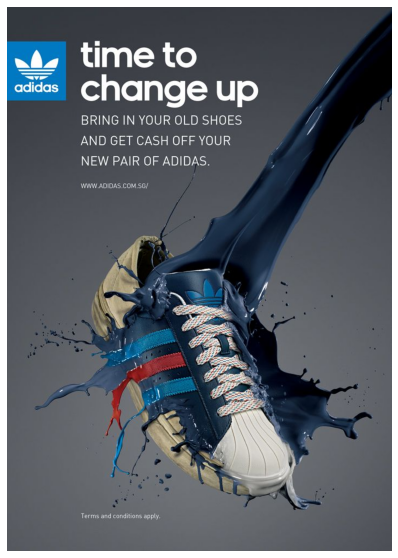

In [213]:
image_show(0)
print(f"Google OCR API : \n {google_ocr_dict['input_1.jpg'][1:]}")
print("------------------")
print(f"Keras-ocr : \n {keras_ocr_dict['input_1.jpg']}")
print("------------------")
print(f"Tesseract : \n {tesseract_dict['input_1.jpg']}")
print("------------------")

- COVIDD-19 이미지

Google OCR API : 
 ['I', 'GOT', 'MY', 'COVID-19', 'VACCINE!', 'You', 'Are', 'Essential.', 'Getting', 'a', 'COVID-19', 'vaccine', 'adds', 'one', 'more', 'layer', 'of', 'protection.', 'www.cdc.gov']
------------------
Keras-ocr : 
 ['igot', 'covidi9', 'my', 'vaccinel', 'you', 'are', 'essential', 'getting', 'covidi9', 'vaccine', 'adds', 'a', 'wwwcdcgov', 'layer', 'of', 'protection', 'one', 'more']
------------------
Tesseract : 
 ['\x0c', 'a', '=n', 'thee', 'a', 'fecevne', 'y', 'e', 'ay', '.', 'of', 'oly', '*', 'Se', '“aie', '\x0c']
------------------


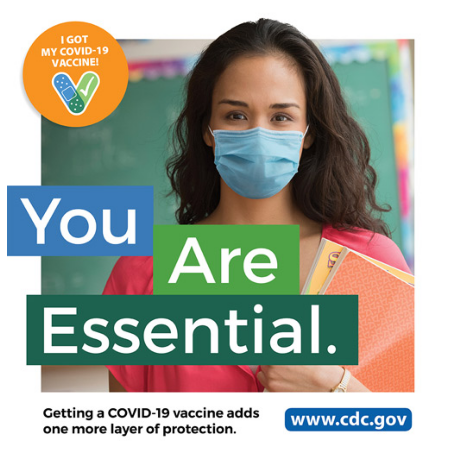

In [214]:
image_show(1)
print(f"Google OCR API : \n {google_ocr_dict['input_4.jpg'][1:]}")
print("------------------")
print(f"Keras-ocr : \n {keras_ocr_dict['input_4.jpg']}")
print("------------------")
print(f"Tesseract : \n {tesseract_dict['input_4.jpg']}")
print("------------------")

- 표지판 이미지

Google OCR API : 
 ['1', 'DowntowNn', 'Parking', '1', 'City', 'Hall', '>', 'Chamber', 'of', 'Commerce', 'E', 'Wingate', 'Hotel', 'E', 'Lourdes', 'College', 'Sylvania']
------------------
Keras-ocr : 
 ['downtown', 'parking', 'city', 'hall', 'chamber', 'of', 'commerce', 'wingate', 'hotel', 'lourdes', 'college', 'syvania']
------------------
Tesseract : 
 ['\x0c']
------------------


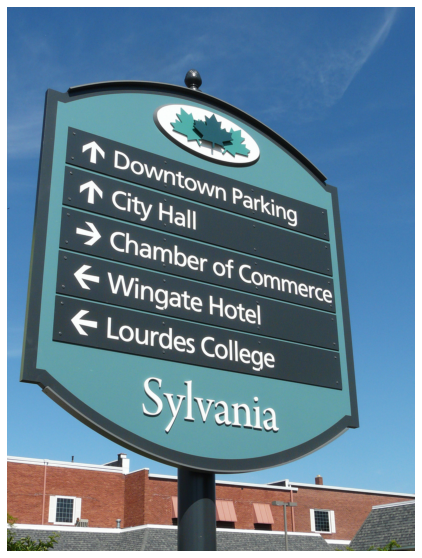

In [215]:
image_show(2)
print(f"Google OCR API : \n {google_ocr_dict['input_2.jpg'][1:]}")
print("------------------")
print(f"Keras-ocr : \n {keras_ocr_dict['input_2.jpg']}")
print("------------------")
print(f"Tesseract : \n {tesseract_dict['input_2.jpg']}")
print("------------------")

- 작고 다양한 글씨 이미지

Google OCR API : 
 ['David', 'Foster', 'Wallace', 'Belored', 'ACHEBE', 'A', 'towering', 'masterpiece', 'by', 'a', 'writer', 'of', 'grnius."', 'INDEPENDENT', 'ROHINTON', 'MISTRY', 'THINGS', 'FALL', 'A', 'FINE', 'BALANCE', 'APART', 'Estraondinary-', 'an', 'astonishing', 'and', 'SLAUGHTERHOUSE', 'vast', 'epic', 'uf', 'contemporary', 'American', 'culture', 'The', 'writer', 'in', 'whosE', 'Company', 'the', 'prison', 'walls', 'fell', 'down', 'NELSON', 'MANDELA', 'Shortlisted', 'for', 'the', 'Booker', 'Prin', 'Guartian', 'NEW', 'YORK', 'TIMES', 'BESTSELLER', 'CORMAC', 'MCCARTHY', 'Alice', 'Walker', 'The', "Handmaid's", 'Tale', 'WINNER', 'OF', 'THE', 'PULITZER', 'PRIZE', 'THE', 'GOD', 'The', 'Color', 'Purple', 'OF', 'The..', 'OD', 'GuardianN', 'S', 'MAT', 'T', 'THIAT', 'CS', 'MARGE', 'PIERCY', 'WOMAN', 'ON', 'THE', 'EDGE', 'OF', 'TIME', 'Margaret', 'ATWO', 'Infinite', 'Jest']
------------------
Keras-ocr : 
 ['david', 's', 'beloved', 'foster', 'achebe', 'wallace', 'unttg', 'unntioes', 'y', 'mo

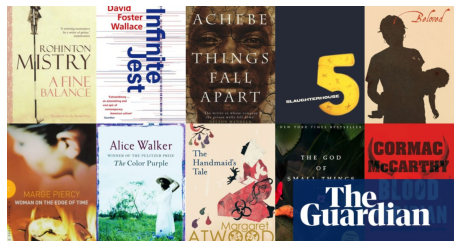

In [216]:
image_show(3)
print(f"Google OCR API : \n {google_ocr_dict['input_3.jpg'][1:]}")
print("------------------")
print(f"Keras-ocr : \n {keras_ocr_dict['input_3.jpg']}")
print("------------------")
print(f"Tesseract : \n {tesseract_dict['input_3.jpg']}")
print("------------------")

## Step4. 결과 분석과 결론 제시
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시합니다.
그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

**서비스의 목적 :** 다양한 상황에서 문자를 판독하여 정보 전달을 용이하게 것을 목적으로 앞을 보지 못하거나, 눈이 나빠서 음성으로 정보를 얻어야하는 사람들에게 문자를 판독하는 서비스   

**서비스를 위한 모듈 실험 :** 제시된 3가지 기능이 아래와 같은 상황에서 어느 정도 잘 작동하는지 비교 분석하는 것을 목표로 한다.   
 
1. 광고이미지에서 말하고자하는 주요 정보를 읽어 냈는가?  
2. 기울어진 안내판의 정보를 읽어 냈는가?  
3. 작고 다양한 글씨체를 읽어 냈는가?  
4. 코로나 관련 상황에서 주요 정보를 읽어 냈는가?  

**평가** 
1. 입력 이미지의 70%의 글자를 인식해내는 것을 기준으로 한다.   
2. 해당 평가에 근접한 모델을 채택하도록 한다.   

**결과**
- Google OCR API  
모든 이미지에서 내용을 대체로 잘 추출하였다. 대소문자 또한 구분을 하여 출력하였다. 
    + 광고이미지의 주요 내용을 잘 출력하였다. 
    + 기울어진 안내판에서는 글씨가 아닌 특수문자나 숫자가 유입되어 출력하였다. 
    + 작고 다양한 글씨체를 다른 모듈보다 잘 출력하였다. 
    + 잘 출력하였다. 광고이미지와 같이 url표기도 완성된 주소로 표기하였다. 
- Keras-ocr  
소문자로 출력이 되었다. 
    + 광고이미지와 covid 안내 문구는 잘 출력하였으나 url표기는 잘려진 채 표기 되었다. 
    + 기울어진 안내판은 google ocr api 보다 text를 잘 출력하였다. 
    + 작고 다양한 글씨는 잘 출력하지 못하였다. 
- Tesseract  
모든면에서 엉망이였다. 기울어진 안내판은 아예 문자를 detect 하지 못했다. config 값을 바꿔서 수행해보았지만, 마찬가지였다. 

**Google OCR API 는 광고이미지, 안내 문구, 작고 다양한 글씨체를 잘 인식하였다. 너무 잘 인식하다 보니 안내판에서는 위쪽 화살표를 1로 보거나, 왼쪽 화살표를 'E'문자로 인식하였다. 하지만 다른 모듈보다 문자 인식에 있어서 제일 나았다.**   

## 느낀점

재미있는 작업이였다. OCR이 실생활에 활용되는 부분이 많은거 같다.   
은행앱에서 신분증을 스캔해서 인증에 사용하는 것이 신기하였는데, 이번 노드를 통해 배울 수 있었다.   
한글 언어팩으로 OCR을 하려 했지만, 잘 되지 않아서 영어 글씨 사진들을 이용했다.   
평가하는 방법에 고민이 있었다.   
결과물을 ditionary에 담아 text를 print해보는 것으로 비교했다.    
눈으로 비교하여 정성적인 방법으로 평가했지만, 긴 글을 평가할 때는 정량적인 방법이 필요할거 같다.    